# HY-2B SCA L2A后向散射系数投影

In [8]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from RSData import *
from HaiYangData import *

import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import io
import cv2

In [10]:
def split_file_day(files):
    # 按照天来划分文件，同一天的内容在一个list里面
    file_list = []
    list = []
    for i in range(len(files)):

        if i == 0:
            list.append(files[i])
            continue

        if (files[i].split('_')[8].split('T')[0]) == (files[i-1].split('_')[8].split('T')[0]):
            list.append(files[i])
        else:
            file_list.append(list)
            list = []
            list.append(files[i])
    file_list.append(list)
    return file_list

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



 def draw_sigmod_0(x_map, y_map, grid_array,save_path = None):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!
    if save_path:
        plt.savefig(save_path,dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    plt.close()
    
    return fig


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 32)

In [48]:
satellite = r'HY2B'
sensor = r'SCA'
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=25000)

# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

dir_path = r"I:\remote_sensing_data\back_scatter\HY-2B"
# 20210608 处理pwp_250_07.h5
files = glob.glob(dir_path + '\*_pwp_250_05.h5')


In [49]:
files = files + glob.glob(dir_path + '\*_pwp_250_03.h5')
files = files + glob.glob(dir_path + '\*_pwp_250_07.h5')

In [50]:
files.sort()

In [53]:
file_list = split_file_day(files)

In [57]:
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

train_data_dir = r'E:\python_workfile\sea_ice_classification\data\train_data'

In [13]:
value_array = np.empty(shape=(1702, 810,5))
grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

for file in file_list[1]:
    with h5py.File(file, mode='r') as f:
        lat = f['cell_lat'][:]
        lon = f['cell_lon'][:]
        sigma0 = f['cell_sigma0'][:]

    sigma0 = sigma0*0.01

    lat[lat > 90] = 0 
    lon[lon > 360] = 0 
    sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

    value_array[:,:,0] = lat
    value_array[:,:,1] = lon
    value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
    value_array[:,:,4] = sigma0
#     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

    x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
    y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
    grid_array[y,x] += value_array[:,:,4]
    grid_num_array[y,x] += 1

In [14]:
grid_array = grid_array / grid_num_array
x_map, y_map = hy_sca.get_map_grid(transformer_back)


<ipython-input-14-02739a0d2a2e>:1: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array


In [20]:
grid_array.shape

(1600, 1600)

<ipython-input-15-8126205d4b35>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


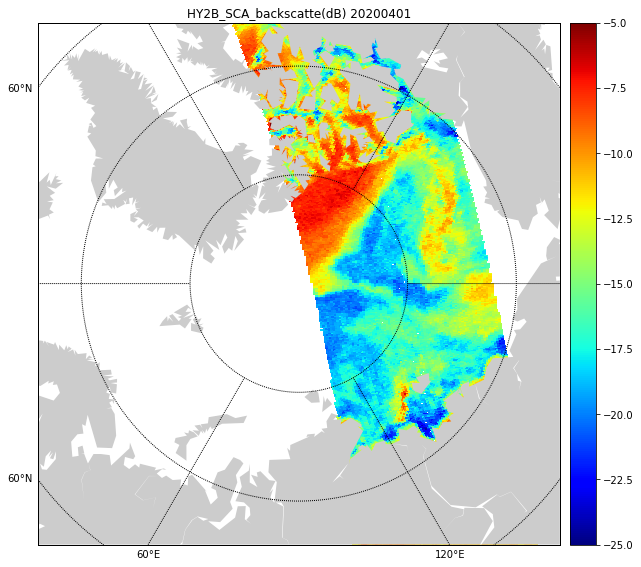

In [15]:
fig = plt.figure(figsize=(9, 9))
fig.add_subplot(111)
fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
cb = hy_m.colorbar(location='right')
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title('HY2B_SCA_backscatte(dB) 20200401')
# you can get a high-resolution image as numpy array!!
plt.show()
plot_img_np = get_img_from_fig(fig)
# np.save((train_data_dir+ '\\npy\\HY2B_sca_sigmod0_'+str(name) + '.npy'), plot_img_np)
# print(name)

In [ ]:
x_map, y_map = hy_sca.get_map_grid(transformer_back)

for files in file_list:
    name = files[0].split('_')[8].split('T')[0]
    value_array = np.empty(shape=(1702, 810,5))
    grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
    grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

    for file in files:
        try:
            with h5py.File(file, mode='r') as f:
                lat = f['cell_lat'][:]
                lon = f['cell_lon'][:]
                sigma0 = f['cell_sigma0'][:]
        except:
            continue
            print(file)
            

        sigma0 = sigma0*0.01

        lat[lat > 90] = 0 
        lon[lon > 360] = 0 
        sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

        value_array[:,:,0] = lat
        value_array[:,:,1] = lon
        value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
        value_array[:,:,4] = sigma0
    #     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

        x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
        y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
        grid_array[y,x] += value_array[:,:,4]
        grid_num_array[y,x] += 1
        
    grid_array = grid_array / grid_num_array

#     fig = draw_sigmod_0(x_map, y_map, grid_array,train_data_dir + '\\pic\\' + str(name) + '.png')
#     fig = draw_sigmod_0(x_map, y_map, grid_array)
#     plot_img_np = get_img_from_fig(fig)
    np.save((train_data_dir+ '\\npy\\grid\\'+str(name) + '.npy'), grid_array)
    print(name)

<ipython-input-58-e675be80b6f2>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array


20190514
20190519
20190520
20190521
20190526
20190527
20190528
20190908
20190909
20190910
20190914
20190915
20190916
20190917
20190923
20190924
20190929
20190930
20191001
20191005
20191006
20191007
20191008
20191013
20191014
20191015
20191019
20191020
20191021
20191022
20191027
20191028
20191029
20191102
20191103
20191104
20191105
20191109
20191110
20191111
20191112
20191116
20191117
20191118
20191119
20191124
20191125
20191126
20191130
20191201
20191202
20191203
20191207
20191208
20191209
20191210
20191214
20191215
20191216
20191217
20191222
20191223
20191224
20191229
20191230
20191231
20200106
20200107
20200112
20200113
20200114
20200119
20200120
20200121
20200126
20200127
20200128
20200202
20200203
20200204
20200209
20200210
20200211
20200216
20200217
20200218
20200223
20200224
20200225
20200301
20200302
20200303
20200308
20200309
20200310
20200314
20200315
20200316
20200317
20200322
20200323
20200324
20200329
20200330
20200331
20200401
20200402
20200403
20200404
20200405
20200406
2

    
    fig = draw_sigmod_0(x_map, y_map, grid_array)
    plot_img_np = get_img_from_fig(fig)

    name = files[6].split('_')[8].split('T')[0]

    np.savez((r'.\\npy\\sigmod0_'+ str(name) + '.npz'), plot_img_np)


# 修改文件名称

In [14]:
import os
import glob

path=r'E:\python_workfile\sea_ice_classification\training4\sigmod0'      

#获取该目录下所有文件，存入列表中
fileList=glob.glob(path+'\\HY2B_sca_sigmod0_'+'*.png')


n=0
for i in fileList:
    
    #设置旧文件名（就是路径+文件名）
    oldname=i   # os.sep添加系统分隔符
    
    #设置新文件名
    newname=path + '\\' +i.split('\\')[-1].split('_')[-1]
    
    os.rename(oldname,newname)   #用os模块中的rename方法对文件改名
    print(oldname,'======>',newname)
    
    n+=1

# 将AARI 与HY-2B daily数据 1天向3天映射

In [49]:
import shutil
sig_dir = r'E:\python_workfile\sea_ice_classification\training4\sigmod0'
aari_dir = r'E:\python_workfile\sea_ice_classification\training4\mask\npy'

sig_files = glob.glob(sig_dir+'\\*.png')
aari_files = glob.glob(aari_dir + '\\*.npy')


In [53]:

i,j = 0,0
while i <len(aari_files)-1:
    while j < len(sig_files)-1:
        aari_day = int(aari_files[i].split('\\')[-1].split('.')[0])
        sig_day = int(sig_files[j].split('\\')[-1].split('.')[0])
        print(aari_day, sig_day)
        if aari_day == sig_day:
            i += 1
            j += 1
        elif (aari_day - sig_day < 3)& (aari_day - sig_day > 0):
            shutil.copyfile(aari_files[i], aari_dir+'\\'+str(sig_day)+'.npy')
            j+=1
            print(aari_files[i],'======>', aari_dir+'\\'+str(sig_day)+'.npy')
        else:
            i+=1

20200407 20200405
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200407.npy ======> E:\python_workfile\sea_ice_classification\training4\mask\npy\20200405.npy
20200407 20200406
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200407.npy ======> E:\python_workfile\sea_ice_classification\training4\mask\npy\20200406.npy
20200407 20200407
20200414 20200412
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200414.npy ======> E:\python_workfile\sea_ice_classification\training4\mask\npy\20200412.npy
20200414 20200413
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200414.npy ======> E:\python_workfile\sea_ice_classification\training4\mask\npy\20200413.npy
20200414 20200414
20200421 20200419
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200421.npy ======> E:\python_workfile\sea_ice_classification\training4\mask\npy\20200419.npy
20200421 20200420
E:\python_workfile\sea_ice_classification\training4\mask\npy\20200421.npy ==

# 将AARI 与HY-2B daily图片 1天向3天映射

In [59]:
import shutil
sig_dir = r'E:\python_workfile\sea_ice_classification\training4\sigmod0\fill_value'
aari_dir = r'E:\python_workfile\sea_ice_classification\training4\mask'

sig_files = glob.glob(sig_dir+'\\*.png')
aari_files = glob.glob(aari_dir + '\\*.png')


In [60]:
len(sig_files)

70

In [61]:
len(aari_files)

71

In [58]:

i,j = 0,0
while i <len(aari_files)-1:
    while j < len(sig_files)-1:
        aari_day = int(aari_files[i].split('\\')[-1].split('.')[0])
        sig_day = int(sig_files[j].split('\\')[-1].split('.')[0])
        print(aari_day, sig_day)
        if aari_day == sig_day:
            i += 1
            j += 1
        elif (aari_day - sig_day < 3)& (aari_day - sig_day > 0):
            shutil.copyfile(aari_files[i], aari_dir+'\\'+str(sig_day)+'.png')
            j+=1
            print(aari_files[i],'======>', aari_dir+'\\'+str(sig_day)+'.png')
        else:
            i+=1

20200407 20200405
E:\python_workfile\sea_ice_classification\training4\mask\20200407.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200405.png
20200407 20200406
E:\python_workfile\sea_ice_classification\training4\mask\20200407.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200406.png
20200407 20200407
20200414 20200412
E:\python_workfile\sea_ice_classification\training4\mask\20200414.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200412.png
20200414 20200413
E:\python_workfile\sea_ice_classification\training4\mask\20200414.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200413.png
20200414 20200414
20200421 20200419
E:\python_workfile\sea_ice_classification\training4\mask\20200421.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200419.png
20200421 20200420
E:\python_workfile\sea_ice_classification\training4\mask\20200421.png ======> E:\python_workfile\sea_ice_classificat